# BICS_ABM
Ethan Roubenoff

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BICS_ABM import BICS_ABM, VaccineRule
import time
from joblib import Parallel, delayed
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm, uniform, randint


/Users/eroubenoff/BICS_ABM/BICS_ABM.py:77: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv")


## Quick, demonstrative example:

----------------------------------------
Parameters passed to simulation:
N_HH:            10000
GAMMA_MIN, _MAX: 48, 96
SIGMA_MIN, _MAX: 72, 168
BETA:            0.05
MU_VEC:          1e-05  0.0001  0.0001  0.001  0.001  0.001  0.01  0.1  0.1  
INDEX_CASES:     5
SEED:            4949
N_VAX_DAILY:     1500
VE1, VE2:        0.75, 0.95
VEW, VEBoost:    0.25, 0.95
ALPHA:           0.25
RHO:             0.9
ISOLATION_MULT.: 0.5
NPI            : 0.75
----------------------------------------
N vertices: 36644
N households: 10000
N household edges 61159
Index cases: 17154  4302  3847  11063  1851  
Day  122 Hour 23 | S:  4109 | E:     0 | Ic:     0 | Isc:     0 | R: 32349 | D:   186 | V1:     0 | V2:     0 | VW: 28735 | VBoost:     0 | Edge counts: Household: 61159 Work  Random      0


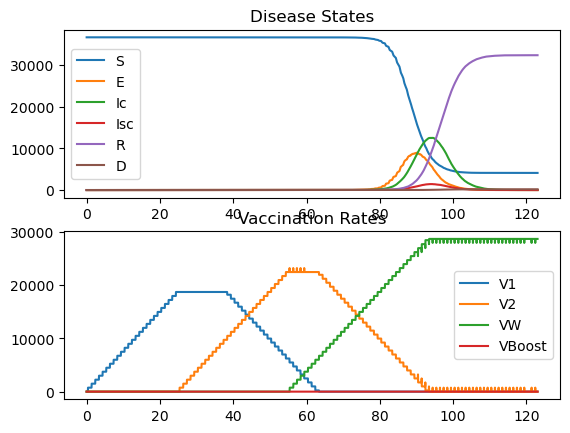

In [2]:
result = BICS_ABM( 
        N_HH = 10000,
        SEED = 4949, 
        RHO = 0.9,
        ALPHA = 0.25,
        BETA = 0.05,
        T0 = 60,
        ISOLATION_MULTIPLIER = 0.5, 
        N_VAX_DAILY = 1500,
        vax_rules = [
            VaccineRule("age > 80"),
            VaccineRule("age > 70"),
            VaccineRule("age > 60"),
            VaccineRule("age > 50", hesitancy = 0.5),
            VaccineRule("age > 40", hesitancy = 0.5),
            VaccineRule("age > 30", hesitancy = 0.5),
            VaccineRule(general = True, hesitancy = 0.5),
        ])

result.plot_trajectory()

In [3]:
# Calculate the effective R0 as beta * average contacts per hour per person * average time infectious
0.01 * np.mean(result.n_edges)/result.S[0] * ((48+96)/2 + (72+168)/2)

3.16659729061045

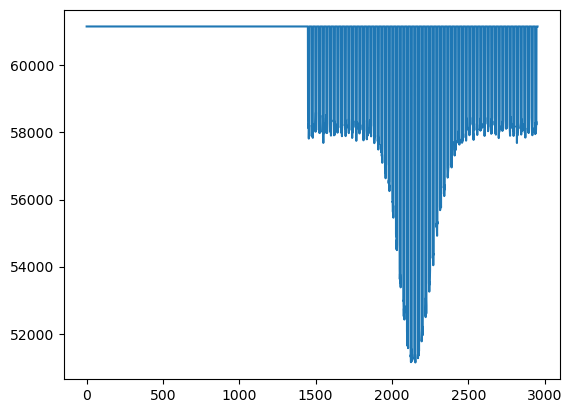

In [4]:
plt.plot(result.n_edges)

# Main analysis

Run simulations that gradually decrease number of nonhousehold contacts required for priority access. Start at 30
and work down. Begin by assuming no asymptomatic transmission and 70% symptomatic rate, no isolation.


Run 10 simulations for each, and chart the number of deaths.

4 vaccine priorities: 
- No vax
- Equal priority vax
- Age priority
- Contact priority

4 transmission scenarios: 
- With all of the above
- With all of the above + prior immunity
- No isolation, no pre/asymptomatic transmission, no NPIs, no prior immunity

## Generate all parameter draws

In [8]:
nsims = 1000
sampler = LatinHypercube(22)
sample = sampler.random(nsims)

gamma_min_v = [int(randint.ppf(x, 0*24, 2*24)) for x in sample[:,0]] 
gamma_max_v = [int(randint.ppf(x, 2*24, 4*24)) for x in sample[:,1]] 
sigma_min_v = [int(randint.ppf(x, 3*24, 5*24)) for x in sample[:,2]] 
sigma_max_v = [int(randint.ppf(x, 5*24, 7*24)) for x in sample[:,3]] 
beta_v = [uniform.ppf(x, 0, .10) for x in sample[:,4]] 
alpha_v = [uniform.ppf(x, 0, .25) for x in sample[:,5]] 
rho_v = [uniform.ppf(x, .7, 1) for x in sample[:,6]] 
isomult_v = [uniform.ppf(x, 0, 1) for x in sample[:,7]] 
npi_v = [uniform.ppf(x, 0.25, 0.75) for x in sample[:,8]]

mu0_v = [uniform.ppf(x, 0.003, 0.005)/100 for x in sample[:,9]] 
mu1_v = [uniform.ppf(x, 0.003, 0.005)/100 for x in sample[:,10]] 
mu2_v = [uniform.ppf(x, 0.058, 0.078)/100 for x in sample[:,11]] 
mu3_v = [uniform.ppf(x, 0.20, 0.26)/100 for x in sample[:,12]] 
mu4_v = [uniform.ppf(x, 0.66, 0.87)/100 for x in sample[:,13]] 
mu5_v = [uniform.ppf(x, 0.66, 0.87)/100 for x in sample[:,14]] 
mu6_v = [uniform.ppf(x, 2.1, 3.0)/100 for x in sample[:,15]] 
mu7_v = [uniform.ppf(x, 6.9, 10.4)/100 for x in sample[:,16]] 
mu8_v = [uniform.ppf(x, 21.8, 36.6)/100 for x in sample[:,17]] 

ve1_v = [uniform.ppf(x, 0.65, 0.75) for x in sample[:,18]]
ve2_v = [uniform.ppf(x, 0.85, 0.95) for x in sample[:,19]]
vew_v = [uniform.ppf(x, 0.25, 0.55) for x in sample[:,20]]
veb_v = [uniform.ppf(x, 0.65, 0.75) for x in sample[:,21]]

In [ ]:
q1_df = pd.read_csv("q1_df.csv")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Day   14 Hour 14 | S:   898 | E:    33 | Ic:   891 | Isc:     5 | R:  1852 | D:    16 | V1:   950 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  1862 Work  Random   4032

Day   14 Hour  9 | S:  3462 | E:    22 | Ic:    67 | Isc:     1 | R:   141 | D:     2 | V1:  1100 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  1882 Work  Random   3998

Day   47 Hour 13 | S:  1814 | E:    55 | Ic:   424 | Isc:     0 | R:  1352 | D:    20 | V1:  1250 | V2:   200 | VW:     0 | VBoost:     0 | Edge counts: Household:  1852 Work  Random   3735

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.9s


Day   13 Hour  7 | S:  3485 | E:    85 | Ic:    85 | Isc:     0 | R:    10 | D:     0 | V1:   650 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  6132 Work  Random      0S:  3633 | E:     2 | Ic:     3 | Isc:     0 | R:     7 | D:     0 | V1:   750 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  1888 Work  Random   3830

Day   29 Hour  8 | S:  3658 | E:     1 | Ic:     6 | Isc:     0 | R:     0 | D:     0 | V1:   250 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  1845 Work  Random   3761

Day   17 Hour  7 | S:  3603 | E:    12 | Ic:    14 | Isc:     0 | R:    17 | D:     0 | V1:   850 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  6046 Work  Random      0

Day   32 Hour 12 | S:  3620 | E:    43 | Ic:    30 | Isc:     0 | R:    12 | D:     1 | V1:   650 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  1870 Work  Random   3600S:  3633 | E:    36 | Ic:    29 | Isc:     0 | R:     7 | D:     1 | V1:   600 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  1830 Work  Random   364662

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   28.5s


Day   14 Hour 16 | S:  3613 | E:     3 | Ic:     5 | Isc:     2 | R:    25 | D:     0 | V1:   750 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  6084 Work  Random      0S:   749 | E:    14 | Ic:   891 | Isc:     0 | R:  1873 | D:    33 | V1:   950 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  1813 Work  Random   3641 0

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   43.5s


Day   17 Hour 12 | S:   836 | E:   102 | Ic:  2192 | Isc:     0 | R:   427 | D:     3 | V1:   800 | V2:     0 | VW:     0 | VBoost:     0 | Edge counts: Household:  1790 Work  Random   3127

Day   10 Hour 14 | S:  2748 | E:    65 | Ic:   286 | Isc:     0 | R:   452 | D:     9 | V1:  1250 | V2:    50 | VW:     0 | VBoost:     0 | Edge counts: Household:  1750 Work  Random   3621

Day   63 Hour  2 | S:  1910 | E:     0 | Ic:     0 | Isc:     0 | R:  1705 | D:    23 | V1:  1250 | V2:  1150 | VW:     0 | VBoost:     0 | Edge counts: Household:  6078 Work  Random      0
S:  2490 | E:    14 | Ic:    14 | Isc:     0 | R:  1023 | D:    19 | V1:  1250 | V2:  1500 | VW:   400 | VBoost:     0 | Edge counts: Household:  5799 Work  Random      0

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:  9.5min
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed: 10.6min
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed: 11.7min
[Parallel(n_jobs=4)]: Do

In [ ]:
# For each sim, figure out which strategy had lowest death and infection rates

print(q1_df.filter(like="_d").idxmin(axis=1).value_counts())
print(q1_df.filter(like="_r").idxmin(axis=1).value_counts())


## Q2: What it index cases come after vaccines have been distributed?

In [ ]:
q2_df = pd.read_csv("q2_df.csv")
# For each sim, figure out which strategy had lowest death and infection rates

print(q2_df.filter(like="_d").idxmin(axis=1).value_counts())
print(q2_df.filter(like="_r").idxmin(axis=1).value_counts())


# Q3: Finding the top % of num_cc to vaccinate

In [ ]:
q3_df = pd.read_csv("q3_df.csv")

In [ ]:

x = [re.findall(r'\d+', x) for x in q3_df.columns]
plot = [0 if "_r" in x else 1 for x in q3_df.columns]

In [ ]:
fix,ax = plt.subplots(2)

q3_df.hist(ax=ax[0])

In [ ]:
fig, ax = plt.subplots(2, figsize=(10,10))

q3_df.filter(like="_r").quantile(.5).plot(ax = ax[0], color = "red")
q3_df.filter(like="_r").quantile(.75).plot(ax = ax[0], color = "black")
q3_df.filter(like="_r").quantile(.25).plot(ax = ax[0], color = "black")
q3_df.filter(like="_r").quantile(.95).plot(ax = ax[0], color = "grey")
q3_df.filter(like="_r").quantile(.05).plot(ax = ax[0], color = "grey")
q3_df.filter(like="_d").quantile(.5).plot(ax=ax[1], color = "red")
q3_df.filter(like="_d").quantile(.25).plot(ax = ax[1], color = "black")
q3_df.filter(like="_d").quantile(.75).plot(ax = ax[1], color = "black")
q3_df.filter(like="_d").quantile(.95).plot(ax = ax[1], color = "grey")
q3_df.filter(like="_d").quantile(.05).plot(ax = ax[1], color = "grey")

plt.show()

# Sensitivity tests

beta: 0.0001 to 0.1

rho (probability of clinical): 0 to 1

alpha (relative infectiousness of pre and asymptomatic): 0 to 1

isolation multiplier: 0 to 1

In [ ]:
# beta vec with no asymptomatic transmission
beta_vec = np.arange(0.001, 0.1 , 0.001)
beta_vec = beta_vec.repeat(10)

t = time.time()


def multi_fn(beta):
    """ Wrapper function for multiprocessing
    
    """
    
    result = BICS_ABM(
        ALPHA = 0,
        RHO = 1,
        N_HH = 1000, BETA = beta, 
        silent = True, 
        N_VAX_DAILY = 0
    )
    
    return (result.R[-1] / (result.S[0] + result.E[0]), result.D[-1] / (result.S[0] + result.E[0]))
    
    
result_vec = Parallel(n_jobs=8, verbose = 10)(delayed(multi_fn)(v) for v in beta_vec)
    
    
t = time.time() - t

print(len(beta_vec), "iterations took", t, "seconds")



In [ ]:


fig, ax = plt.subplots(2)
ax[0].scatter(beta_vec, [x[0] for x in result_vec])
ax[1].scatter(beta_vec, [x[1] for x in result_vec])

# Jointly vary the isolation multiplier and the proportion of symptomatic cases

In [ ]:
isomult_vec = np.arange(0, 1, 0.1)
rho_vec = np.arange(0, 1, 0.1)
isomult_vec, rho_vec = np.meshgrid(isomult_vec, rho_vec)
isomult_vec = isomult_vec.flatten().repeat(10)
rho_vec = rho_vec.flatten().repeat(10)


t = time.time()


def multi_fn(i, r):
    """ Wrapper function for multiprocessing
    
    """
    
    result = BICS_ABM(
        RHO = r,
        ISOLATION_MULTIPLIER = i, 
        N_HH = 1000, BETA = 0.01, 
        silent = True, 
        N_VAX_DAILY = 0
    )
    
    return (result.R[-1] / (result.S[0] + result.E[0]), result.D[-1] / (result.S[0] + result.E[0]))
    
    
result_vec = Parallel(n_jobs=8, verbose = 10)(delayed(multi_fn)(*x) for x in zip(isomult_vec, rho_vec))
    
    
t = time.time() - t

print(len(result_vec), "iterations took", t, "seconds")



In [ ]:
dv = np.array([x[0] for x in result_vec]).reshape((10,10,10))
iv = np.array([x[1] for x in result_vec]).reshape((10,10,10))

In [ ]:
plt.imshow(iv, extent = [0,1,0,1])
plt.title("% Of population infected")
plt.xlabel("Isolation Multiplier")
plt.ylabel("Proportion of cases that are clinical")
plt.show()

In [ ]:
plt.imshow(dv, extent = [0,1,0,1])
plt.title("% Of population dead")
plt.xlabel("Isolation Multiplier")
plt.ylabel("Proportion of cases that are clinical")
plt.show()

# Speed test

Not whole necessary, but kind of fun. Seems like there is no benefit past 4 or 8 threads.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  4.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  

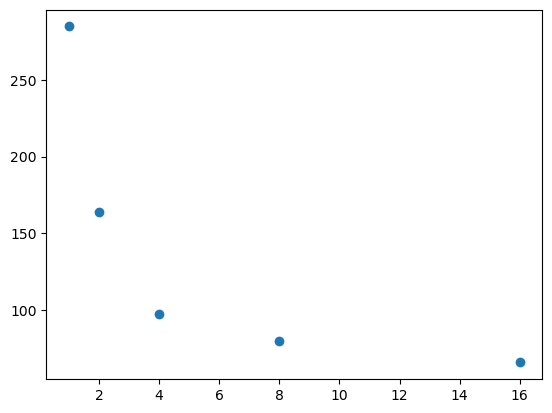

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:77: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv")
/Users/eroubenoff/BICS_ABM/BICS_ABM.py:77: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv")
/Users/eroubenoff/BICS_ABM/BICS_ABM.py:77: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv")
/Users/eroubenoff/BICS

In [5]:
if True:
    reps = np.arange(1, 100, 1)



    def multi_fn(i):
        """ Wrapper function for multiprocessing

        """

        result = BICS_ABM(
            N_HH = 1000, 
            silent = True, 
        )

        return 0


    tlist = list()
    jlist = [2, 4, 8, 16]
    for jobs in jlist:
        t = time.time()
        Parallel(n_jobs=jobs, verbose = 10)(delayed(multi_fn)(v) for v in reps)
        t = time.time() - t
        tlist.append(t)

    plt.scatter(jlist, tlist)